# Выбор локации для скважины

## Импортирую библиотеки

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Считываю файлы

In [166]:
# Данные будут храниться в словаре df_dict
files_remote = ['/datasets/geo_data_0.csv', '/datasets/geo_data_1.csv', '/datasets/geo_data_2.csv']
files_local = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']
df_dict = {}

for i in range(3):
    if os.path.exists(files_remote[i]):
        df = pd.read_csv(files_remote[i])
        df_dict['df' + str(i)] = df
    elif os.path.exists(files_local[i]):
        df = pd.read_csv(files_local[i])
        df_dict['df' + str(i)] = df
    else:
        print('Something is wrong. Please, check file path.')

In [167]:
# В каждом df есть столбец id, который не потребуется для обучения, поэтому удалю его и сразу проверю результат
for key, item in df_dict.items():
    df_dict[key].drop('id', axis=1, inplace=True)
    df_dict[key].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1 

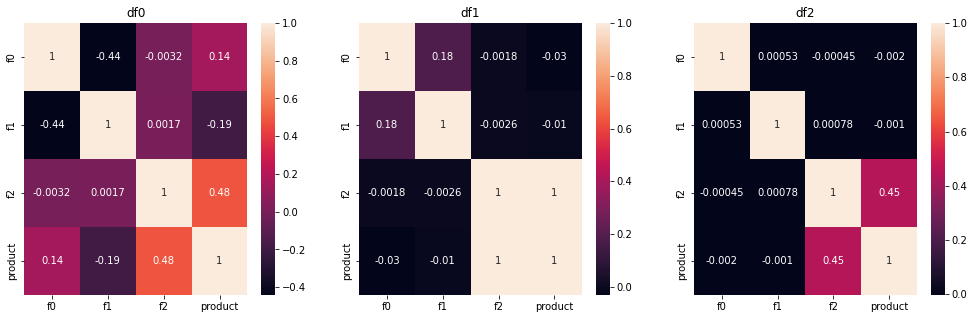

In [168]:
fig, ax = plt.subplots(1, 3, figsize=(17,5))
count = 0

for key, item in df_dict.items():
    sns.heatmap(item.corr(), annot=True, ax=ax[count])
    ax[count].set_title(key)
    count+=1

Наблюдается сильная корреляция между f2 и product в df1.

In [169]:
# Проверю уникальные значения в product
for key, item in df_dict.items():
    print(f'Number of unique values in {key}:', df_dict[key]['product'].nunique())

Number of unique values in df0: 100000
Number of unique values in df1: 12
Number of unique values in df2: 100000


Вывод.  
При обучении моделей, df1 должна предсказывать лучше остальных, посколько уникальных значений всего 12, соответственно, данных для обучения очень много.

## Обучение моделей для каждого региона

In [170]:
# Создам словари, в которых буду хранить RMSE, R2_score, predicted mean, true mean
rmse_dict = {}
r2_score_dict = {}
pred_mean_dict = {}
true_mean_dict = {}

# Создам df, в которых буду хранить df_predicted и df_y
df_predicted = pd.DataFrame()
df_target = pd.DataFrame()

# В цикле буду обучать модели и записывать полученные результаты в словарях
for key, item in df_dict.items():
    
    X = df_dict[key].drop('product', axis=1)
    y = df_dict[key]['product']
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)
    
    model = LinearRegression()
    model.fit(X_train, y_train)   
    predicted_valid = model.predict(X_valid)
    
    mse = mean_squared_error(y_valid, predicted_valid)
    
    # Заполняю словари
    rmse_dict[key] = mse**0.5
    r2_score_dict[key] = model.score(X_train, y_train)
    pred_mean_dict[key] = predicted_valid.mean() 
    true_mean_dict[key] = y_valid.mean()
    
    # Заполняю df
    df_predicted[key] = predicted_valid
    df_target[key] = y_valid

# Верну индексы у полученных df
df_target = df_target.reset_index(drop=True)
df_predicted = df_predicted.reset_index(drop=True)

In [171]:
# Выведу таблицу с результатами
pd.DataFrame(data=[rmse_dict, r2_score_dict, pred_mean_dict, true_mean_dict],
             index=['RMSE', 'R2', 'PRED MEAN', 'TRUE MEAN'])

,df0,df1,df2
RMSE,37.481009,0.887257,40.312907
R2,0.273971,0.999624,0.200214
PRED MEAN,92.271449,69.151624,94.707531
TRUE MEAN,92.466785,69.154361,95.471317


Вывод.  

Лучше всего была предсказана модель с локацией df1, т.к. в стандартное отклонение (RMSE) всего 0.89 при среднем значении 69.15.   
Можно считать предсказания этой модели надежными, по сравнению с остальными, несмотря на то, что среднее уступает. R2 практически равен 1, что говорит о хорошо обученной модели. Для будущего изучения подходит только df1.

## Расчет прибыли

In [172]:
# Условие
budget = 10*10**9 # 10 млрд. рублей
total_spots = 500 # исследуют 500 точек
best_spots = 200 # выбирают 200 лучших с помощью машинного обучения
barrel_income = 450000 # доход с тысячи баррелей (единица продукта)

In [173]:
# Подсчет бюджета на бурение одной скважины
cost_well = budget/best_spots
print(f'Бюджет на бурение одной скважины: {round(cost_well, 1)} руб.')

Бюджет на бурение одной скважины: 50000000.0 руб.


In [174]:
# Достаточный объем сырья для безубыточной разработки скважины
volume = cost_well/barrel_income
print(f'Достаточный объем сырья для безубыточной разработки скважины: {round(volume, 1)} тыс. баррелей.')

Достаточный объем сырья для безубыточной разработки скважины: 111.1 тыс. баррелей.


## Функция для расчета прибыли

In [175]:
# Функция для подсчета дохода по предсказанным данным
def revenue(target, probabilities, count=200):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return barrel_income * selected.sum() - budget

In [176]:
# Расчет прибыли
print('Прибыль локации 0: {:.3f} млрд. руб.'.format(revenue(df_target['df0'], df_predicted['df0'])/10**9))
print('Прибыль локации 1: {:.3f} млрд. руб.'.format(revenue(df_target['df1'], df_predicted['df1'])/10**9))
print('Прибыль локации 2: {:.3f} млрд. руб.'.format(revenue(df_target['df2'], df_predicted['df2'])/10**9))

Прибыль локации 0: 3.363 млрд. руб.
Прибыль локации 1: 2.415 млрд. руб.
Прибыль локации 2: 2.624 млрд. руб.


Вывод.  
Достаточный объем сырья для безубыточной разработки скважины: 111.1 тыс. баррелей.  
Средние объемы предсказанных и target меньше 111.1 тыс. баррелей. Все скважины убыточные.

## Подсчет рисков и прибыли для каждого региона

In [177]:
# Техникой Bootstrap нахожу распределение прибыли
state = np.random.RandomState(12345)
df_values = pd.DataFrame()  # df с распределениями по локациям

for i in range(3):
    
    empty_list = []  # лист с распределениями прибыли

    for _ in range(1000):
        
        target_subsample = df_target.iloc[:, i].sample(500, replace=True, random_state=state)
        probs_subsample = df_predicted.iloc[:, i][target_subsample.index]
        result = revenue(target_subsample, probs_subsample, 200)
        empty_list.append(result)
        
    df_values['df' + str(i)] = empty_list

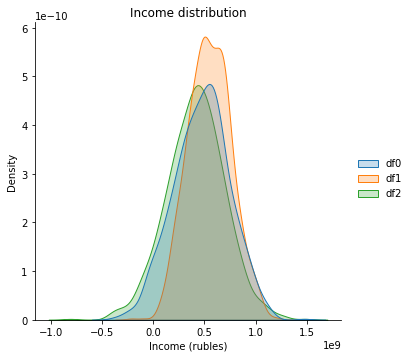

In [178]:
# Диаграмма распределений
sns.displot(df_values, kind='kde', fill=True)
plt.xlabel('Income (rubles)')
plt.title('Income distribution')
plt.show()

In [179]:
# Средняя прибыль
print('Средняя прибыль в локации 0: {:.2f} млрд. руб.'.format(df_values['df0'].mean()/10**9))
print('Средняя прибыль в локации 1: {:.2f} млрд. руб.'.format(df_values['df1'].mean()/10**9))
print('Средняя прибыль в локации 2: {:.2f} млрд. руб.'.format(df_values['df2'].mean()/10**9))

Средняя прибыль в локации 0: 0.47 млрд. руб.
Средняя прибыль в локации 1: 0.55 млрд. руб.
Средняя прибыль в локации 2: 0.41 млрд. руб.


In [180]:
# Расчет 95% доверительного интервала для среднего значения прибыли
conf_interval_dict = {}
quantile_low_dict = {}
quantile_high_dict = {}
mean_dict = {}
risks_dict = {}

for i in range(3):
    
    conf_interval = st.t.interval(0.95, len(df_values.iloc[:, i]) - 1, df_values.iloc[:, i].mean(), df_values.iloc[:, i].sem())
    quantile_low = df_values.iloc[:, i].quantile(0.025)
    quantile_high = df_values.iloc[:, i].quantile(0.975)
    mean_value = df_values.iloc[:, i].mean()
    risk_value = (df_values.iloc[:, i] < 0).mean()
    
    conf_interval_dict['df' + str(i)] = list(map(lambda x: round(x/10**9, 3), conf_interval))
    quantile_low_dict['df' + str(i)] = round(quantile_low/10**9, 3)
    quantile_high_dict['df' + str(i)] = round(quantile_high/10**9, 3)
    mean_dict['df' + str(i)] = round(mean_value/10**9, 3)
    risks_dict['df' + str(i)] = risk_value * 100

In [181]:
# Вывожу таблицу с результатами
pd.DataFrame(data=[mean_dict, conf_interval_dict, quantile_low_dict, quantile_high_dict, risks_dict],
             index=['Mean', '95% interval (mean)', '2.5% quant.', '97.5% quant', 'Negative profit risk (%)'])

,df0,df1,df2
Mean,0.472,0.549,0.414
95% interval (mean),"[0.455, 0.489]","[0.536, 0.562]","[0.396, 0.432]"
2.5% quant.,-0.061,0.165,-0.141
97.5% quant,0.981,0.974,0.971
Negative profit risk (%),4.7,0.2,7.4


## Вывод

Наилучший выбор региона для бурения скважин из трех представленных - локация 1 (или df1), потому-что:  

1) Средняя прибыль 0.549 млрд. руб - наибольшая среди всех трех локаций;  
2) Наименьший риск отрицательной прибыли;  
3) R2 score данной локации - 0.99, по причине того, что целевых признаков было всего 12, что говорит о том, что пробы были взяты по несколько раз.  

В целом, все локации убыльные, но если выбирать из трех предложенных, вторая - прибыльней остальных.